# Initial Imports & Setup

Use Python Data Analysis Libraries to make graphs. 

In [35]:
import pandas as pd
import numpy as np
import glob as glob
import shutil
import os
import datetime as datetime
import altair as alt
from selenium import webdriver

# Importing Data into Dataframe

Create pandas dataframe from folder of CSV files.

Assumes:

* **./files/names.csv**: CSV File with Provider/Clinic Names, etc. Names is used to determine active providers/clinics. (So if there's no name, it wont get evaluated later -- say, for example, after Everson Closes.
* **./files/metrics.csv**: CSV File with Metrics information (Display Name, Category, Target, etc.)
* **./data/(Zero-Padded Date at beginning of CSVs from Meridos).csv**: Files from Automatic weekly report from Meridios

In [74]:
names = pd.read_csv('./files/names.csv', index_col='MeridiosName')
metrics = pd.read_csv('./files/metrics.csv', dtype={'MeridiosMetric':object, 'Metric':object})
metrics.set_index('MeridiosMetric', inplace=True)

df = pd.DataFrame()

files = glob.glob('./data/*.csv')
for file in files:
    filedf = pd.read_csv(file,
                        usecols=["NAME","Metricname","SeenNum","SeenDenom"])
    # Prettier Names
    filedf = filedf.rename(columns={'NAME': 'MeridiosName',
                                    'Metricname': 'MeridiosMetric',
                                    'SeenNum': 'Numerator', 
                                    'SeenDenom': 'Denominator'})

    # Add Lookup Columns
    filedf['Name'] = filedf.MeridiosName.map(names.Name)
    filedf['Type'] = filedf.MeridiosName.map(names.Type)
    filedf['Clinic'] = filedf.MeridiosName.map(names.Clinic)
    filedf['Metric'] = filedf.MeridiosMetric.map(metrics.Metric)
        
    filename_parts = file[7:-4].split(' ')
    # 0 Padded Dates with Dots. 03.15.2018
    if (len(str(filename_parts[0])) is 10):
        filedf['Date'] = datetime.datetime.strptime(filename_parts[0], "%m.%d.%Y")
        # Who are we kidding with precision. Round to Basis points
        filedf['Percentage'] = round(filedf['Numerator'] / filedf['Denominator'] * 100, 2)

        # Now delete the 'raw' columns from import
        filedf.drop("MeridiosName", axis=1, inplace=True)
        filedf.drop("MeridiosMetric", axis=1, inplace=True)
        filedf.drop("Numerator", axis=1, inplace=True)
        filedf.drop("Denominator", axis=1, inplace=True)
    
        df = df.append(filedf) 
    else:
        print("CSV Data File doesn't have Zero-Padded Date at beginning.")
#df.dtypes
df.head()
#df.info()
#df.describe()
#df.columns
#df.Metric.unique()

,Name,Type,Clinic,Metric,Date,Percentage
0,Steven Alexander,Individual,LFM,AAA,2018-04-23,38.10
1,Steven Alexander,Individual,LFM,NaN,2018-04-23,26.39
2,Steven Alexander,Individual,LFM,NaN,2018-04-23,8.23
3,Steven Alexander,Individual,LFM,Chlamydia,2018-04-23,NaN
4,Steven Alexander,Individual,LFM,Colorectal Screen,2018-04-23,71.09


## Validations:

* Does Data include new MeridiosName, New Metric items? (Has the underlying report changed?)
* Should we keep a list of already imported data and do some message to clarify after new data is available?

Currently no validations. But should automate checks that new data from report is accurate. 

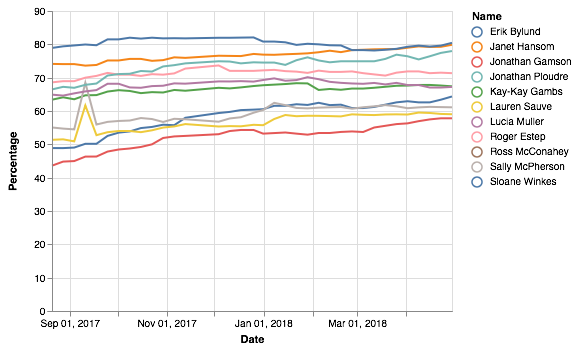

In [75]:
chart = alt.Chart(df[(df['Metric']=="Pap Smears") & (df['Type']=='Individual') & (df['Clinic']=='NCFP')]).mark_line().encode(
    x='Date',
    y='Percentage',
    color='Name',
    tooltip='Name'
)
chart

#for metric in df.Metric.unique():
#    make_fcn_summary_graphs(metric)
    


# Matplotlib Graphs

These graphs are a first attempt to make individual folders. Roughly 1200 pictures from dataframe. 

Creates ./output/ folder with SVG files and an index.html file. 

In [23]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

# Matplotlib Specifics
# %matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = "Bitstream Vera Sans"
plt.rcParams["figure.titleweight"] = 'Bold'
plt.rcParams['figure.titlesize'] = 'xx-large'

for name in df.Name.unique():
#name = 'NCFP'

    foldername = name.replace(" ", "_")

    Provider = df[df['Name'] == name]
    Provider.dropna(inplace=True)

    for number, metric in enumerate(Provider.Metric.unique()):
        ProviderMetric = Provider[Provider['Metric'] == metric]
        ax = ProviderMetric.plot(x="Date", y="Percentage", legend=False, ylim=(0,100), figsize=(6,6))
        ax.set_xlabel("")

        # Let's Do ever third tick mark (quarters)
        ax.set_xticks(ax.get_xticks()[::3])
        fig = ax.get_figure()
        fig.patch.set_facecolor('none')
        ax.patch.set_facecolor('white')
        ax.patch.set_alpha(0.8)
        fig.suptitle(metric, fontsize=20, fontweight='bold')
        fig.tight_layout(pad=2)

        metricfilename = metric.replace(" ", "_")
        if not os.path.exists("./output/" + foldername):
            os.makedirs("./output/" + foldername)
        fig.savefig("./output/" + foldername + "/" + metricfilename + ".svg", facecolor=fig.get_facecolor(), edgecolor='none')
        plt.close(fig)

    shutil.copyfile('./files/index.html', './output/' + foldername + '/index.html') 


/Users/jonathan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jonathan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


FileNotFoundError: [Errno 2] No such file or directory: './output/BellB/index.html'